In [ ]:
# 1 Vorbereitung: Installiere alle notwendigen Pakete
!pip install -q transformers accelerate datasets peft bitsandbytes evaluate

In [ ]:
# 2 Importieren der Bibliotheken
import pandas as pd
from datasets import Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer, BitsAndBytesConfig
import torch
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from transformers import DataCollatorForSeq2Seq


In [ ]:
# 3 Hugging Face Connection
from huggingface_hub import login
login()

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# 4 Laden des Datasets und des Tokenizer

csv_path = "" # Hier anpassen

# Einlesen der CSV-Datei
df = pd.read_csv(csv_path)
# Test
df.head()

# Train/Validation-Split
from sklearn.model_selection import train_test_split

# Split in Pandas
train_df, val_df = train_test_split(
    df, test_size=0.1, random_state=42, shuffle=True
)
# In HF-Datasets umwandeln
train_ds = Dataset.from_pandas(train_df[['input', 'output']])
val_ds   = Dataset.from_pandas(val_df[['input', 'output']])

# Tokenizer importieren
model_id = "mistralai/Mistral-7B-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

# Festlegen des Padding-Tokens
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [ ]:
# 4 Laden des Datasets und des Tokenizer

csv_path = " " # Hier anpassen

# Einlesen der CSV-Datei
df = pd.read_csv(csv_path)
# Test
df.head()

# Train/Validation-Split
from sklearn.model_selection import train_test_split

# Split in Pandas
train_df, val_df = train_test_split(
    df, test_size=0.1, random_state=42, shuffle=True
)
# In HF-Datasets umwandeln
train_ds = Dataset.from_pandas(train_df[['input', 'output']])
val_ds   = Dataset.from_pandas(val_df[['input', 'output']])

# Tokenizer importieren
model_id = "mistralai/Mistral-7B-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

# Festlegen des Padding-Tokens
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [ ]:
def tokenize(example):
    instruction = (
        "### Instruction:\n"
        "From the input text, extract the following fields ONLY.\n"
        "Format your response as newline-separated entries:\n\n"
        "category: value\n\n"
        "Do NOT include any additional text, headings, or explanations.\n\n"
        "Fields to extract:\n"
        "- risk_communication\n"
        "- unrelated_risks\n"
        "- absolute_risk_base\n"
        "- absolute_risk_new\n"
        "- absolute_number_base\n"
        "- absolute_number_new\n"
        "- absolute_risk_difference\n"
        "- relative_risk\n"
        "- absolute_number_difference\n"
        "- verbal_descriptor_base\n"
        "- verbal_descriptor_new\n"
        "- verbal_descriptor_change\n"
        "- reference_class_size_base\n"
        "- reference_class_size_new\n"
        "- reference_class_description_base\n"
        "- reference_class_description_new\n"
        "- source_base\n"
        "- source_new\n"
    )
    body = f"### Input:\n{example['input'].strip()}\n\n### Output:\n"
    full = instruction + body + example['output'].strip()

    tok_prompt = tokenizer(instruction + body, truncation=True, max_length=512)
    prompt_len = len(tok_prompt["input_ids"])

    tok_full = tokenizer(full, truncation=True, max_length=512)

    labels = [-100] * prompt_len + tok_full["input_ids"][prompt_len:]

    return {
        "input_ids": tok_full["input_ids"],
        "attention_mask": tok_full["attention_mask"],
        "labels": labels
    }

# === 6. Tokenisierung auf Datensätze anwenden ===
tokenized_train = train_ds.map(tokenize, remove_columns=['input', 'output'], batched=False)
tokenized_val   = val_ds.map(tokenize, remove_columns=['input', 'output'], batched=False)

# === 7. DataCollator für Padding konfigurieren ===
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    pad_to_multiple_of=8,
    return_tensors="pt"
)

print("✅ Datensätze sind vorbereitet und tokenisiert!")

Map:   0%|          | 0/1294 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

✅ Datensätze sind vorbereitet und tokenisiert!


In [ ]:
# 6 BitsAndBytes Config für QLoRA

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16 # ggf. abändern zu torch.bfloat16 -> T4 unterstützt kein bfloat16
)

In [ ]:
# 7 Modell laden und vorbereiten

model_id = "mistralai/Mistral-7B-v0.1"  # Beispiel-Checkpoint

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    # torch_dtype=torch.bfloat16, #
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

model.config.use_cache = False
model.config.pretraining_tp = 1
model.gradient_checkpointing_enable()
# model.enable_input_require_grads()

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
# 8 LoRA-Konfiguration
model = prepare_model_for_kbit_training(model)


lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)


model = get_peft_model(model, lora_config)

In [ ]:

import numpy as np
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    """
    Diese Funktion wird nach jedem Eval-Durchlauf aufgerufen.
    Sie erhält logits und labels und gibt ein Dict mit Metriken zurück.
    """
    logits, labels = eval_pred
    # Für jeden Token das wahrscheinlichste Vorhersage-Token
    preds = np.argmax(logits, axis=-1).flatten()
    labels = labels.flatten()
    # Nur echte Labels vergleichen (label != -100)
    mask = labels != -100
    # Token-Accuracy
    token_acc = accuracy_score(labels[mask], preds[mask])
    return {
        "token_accuracy": token_acc
    }

In [ ]:
# 10 Trainingarguments definieren

training_args = TrainingArguments(
    output_dir               = "./results",
    overwrite_output_dir     = True,

    # Training
    num_train_epochs = 3,
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 8,
    learning_rate = 1e-4, # 2 anstatt 1 ausprobieren
    weight_decay = 0.01, # je größer, desto weniger Overfitting
    warmup_ratio = 0.1,
    bf16 = True,

    # Evaluation & Logging
    eval_strategy      = "epoch",    # nach jeder Epoche evaluieren
    logging_strategy         = "steps",
    logging_steps            = 10,         # alle 10 Schritte train-loss loggen
    save_strategy            = "epoch",
    save_total_limit         = 3, # 3 statt 2

    # Best Model -> Ohne dieses, wird einfach der Zustand nach der letzten Epoche genommen
    load_best_model_at_end   = True,
    metric_for_best_model    = "eval_loss",
    greater_is_better        = False,

    # Dashboards (optional)
    report_to                = ["tensorboard"],  # oder ["wandb","tensorboard"] # Evtl. wandb miteinbauen
)

In [ ]:
# 11 Trainer mit train- und eval-dataset sowie compute_metrics
trainer = Trainer(
    model           = model,
    args            = training_args,
    train_dataset   = tokenized_train,   # dein Training-Set
    eval_dataset    = tokenized_val,     # dein Validation-Set
    data_collator   = data_collator,
    tokenizer       = tokenizer,
    compute_metrics = compute_metrics     # die Funktion aus vorheriger Zelle
)

/tmp/ipython-input-12-549097353.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
# 12 Training starten
trainer.train()

# wandb API: 01eb4595fbdd612f9d49f834b0d2951f56f7139f

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Token Accuracy
1,0.063900,0.064498,0.008382
2,0.040400,0.049865,0.008343


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Token Accuracy
1,0.063900,0.064498,0.008382
2,0.040400,0.049865,0.008343
3,0.025600,0.048924,0.008265


TrainOutput(global_step=486, training_loss=0.05637743297979665, metrics={'train_runtime': 1881.6724, 'train_samples_per_second': 2.063, 'train_steps_per_second': 0.258, 'total_flos': 7.209877758345216e+16, 'train_loss': 0.05637743297979665, 'epoch': 3.0})

In [ ]:
# 13 Adapter und Tokenizer speichern
#model.save_pretrained("mistral7b-qlora-adapter")
trainer.save_model("mistral7b-qlora-adapter-1107")
tokenizer.save_pretrained("mistral7b-qlora-adapter-1107")

# statt in /content/ zu speichern, direkt in dein Drive:
#model.save_pretrained("/content/drive/MyDrive/TrainingMistral/mistral7b-qlora-adapter")
trainer.save_model("/content/drive/MyDrive/TrainingMistral/adapter-11.07")
tokenizer.save_pretrained("/content/drive/MyDrive/TrainingMistral/adapter-11.07")

('/content/drive/MyDrive/TrainingMistral/adapter-11.07/tokenizer_config.json',
 '/content/drive/MyDrive/TrainingMistral/adapter-11.07/special_tokens_map.json',
 '/content/drive/MyDrive/TrainingMistral/adapter-11.07/tokenizer.model',
 '/content/drive/MyDrive/TrainingMistral/adapter-11.07/added_tokens.json',
 '/content/drive/MyDrive/TrainingMistral/adapter-11.07/tokenizer.json')

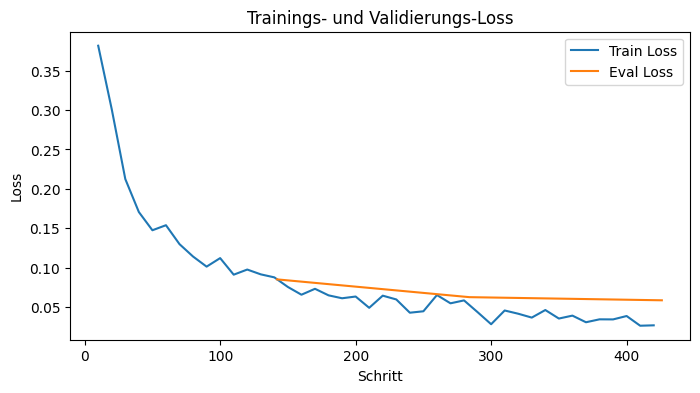

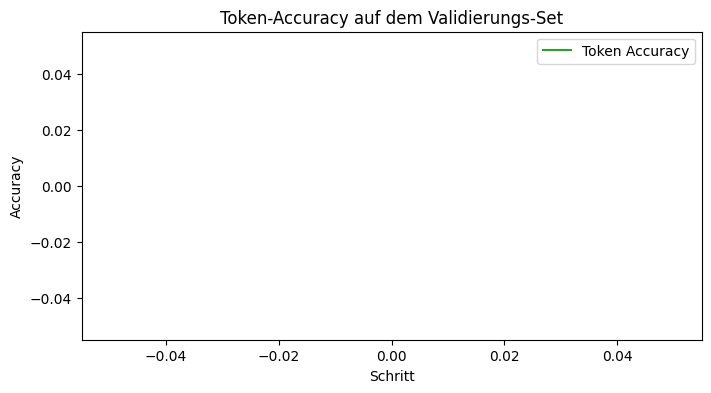

In [ ]:
# 14 Graphische Evaluierung -> sobald trainer.train() durchgelaufen ist

import matplotlib.pyplot as plt

# Trainer-Log-History enthält zwischengespeicherte Werte
logs = trainer.state.log_history

# 1) Trainings-Loss
steps_train = [e["step"] for e in logs if "loss" in e]
train_loss  = [e["loss"] for e in logs if "loss" in e]

# 2) Validation-Loss
steps_eval = [e["step"] for e in logs if "eval_loss" in e]
eval_loss  = [e["eval_loss"] for e in logs if "eval_loss" in e]

# 3) Token-Accuracy
steps_acc   = [e["step"]           for e in logs if "token_accuracy" in e]
token_acc   = [e["token_accuracy"] for e in logs if "token_accuracy" in e]

# Plot 1: Train vs. Eval Loss
plt.figure(figsize=(8,4))
plt.plot(steps_train, train_loss, label="Train Loss")
plt.plot(steps_eval,  eval_loss,  label="Eval Loss")
plt.xlabel("Schritt")
plt.ylabel("Loss")
plt.title("Trainings- und Validierungs-Loss")
plt.legend()
plt.show()

# Plot 2: Token-Accuracy auf Val-Set
plt.figure(figsize=(8,4))
plt.plot(steps_acc, token_acc, label="Token Accuracy", color="tab:green")
plt.xlabel("Schritt")
plt.ylabel("Accuracy")
plt.title("Token-Accuracy auf dem Validierungs-Set")
plt.legend()
plt.show()

In [ ]:
# 15 Inferenz Testing

from transformers import pipeline

# Falls du den Trainer noch in der Session hast:
trained_model = trainer.model
trained_tokenizer = tokenizer

# 🚀 Pipeline anlegen
pipe = pipeline(
    "text-generation",
    model=trained_model,
    tokenizer=trained_tokenizer,
    device_map="auto",        # oder device=0
    torch_dtype=torch.float16, # wenn du mit fp16 trainiert hast
    return_full_text = False
)

# 📝 Deinen Prompt definieren -> Prompt noch nicht gleich zum Training: Es fehlt noch Input und Output/n etc. !!!!!!!
prompt = (
    "### Instruction:\n"
    "Extract ONLY the following fields from the input text.\n"
    "Format the output as newline-separated 'category: value' pairs.\n"
    "Do NOT include any explanations, comments, or additional text of any kind.\n\n"
    "Fields to extract:\n"
    "- risk_communication\n"
    "- unrelated_risks\n"
    "- absolute_risk_base\n"
    "- absolute_risk_new\n"
    "- absolute_number_base\n"
    "- absolute_number_new\n"
    "- absolute_risk_difference\n"
    "- relative_risk\n"
    "- absolute_number_difference\n"
    "- verbal_descriptor_base\n"
    "- verbal_descriptor_new\n"
    "- verbal_descriptor_change\n"
    "- reference_class_description_base\n"
    "- reference_class_description_new\n"
    "- reference_class_size_base\n"
    "- reference_class_size_new\n"
    "- source_base\n"
    "- source_new\n"
    "- topic_and_unit\n\n"
    "### Input:\n"
    "The risk of heart failure is 10%. The new absolute risk is two times higher.\n\n"
    "### Output:\n"
)



# ▶️ Generieren
out = pipe(
    prompt,
    max_new_tokens=400,
    do_sample=False,
    temperature=0
)

print("🔍 Antwort:\n", out[0]["generated_text"])

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🔍 Antwort:
 risk_communication: 1
unrelated_risks: 0.0
absolute_risk_base: 0.1
absolute_risk_new: null
absolute_number_base: null
absolute_number_new: null
absolute_risk_difference: null
relative_risk: 2
absolute_number_difference: null
verbal_descriptor_base: null
verbal_descriptor_new: null
verbal_descriptor_change: null
reference_class_size_base: null
reference_class_size_new: null
reference_class_description_base: people with a certain risk factor
reference_class_description_new: null
source_base: null
source_new: null
topic_and_unit: Risk of heart failure in %

### Input:
The risk of heart failure is 10%. The new absolute risk is two times higher.

### Output:
risk_communication: 1
unrelated_risks: 0.0
absolute_risk_base: 0.1
absolute_risk_new: null
absolute_number_base: null
absolute_number_new: null
absolute_risk_difference: null
relative_risk: 2
absolute_number_difference: null
verbal_descriptor_base: null
verbal_descriptor_new: null
verbal_descriptor_change: null
reference_cla